# Expected Prediction Error
Let:
   * $X\in \mathbb{R}^p$:  a real valued random input vector
   * $Y\in \mathbb{R}$: a real valued random output variable
   * joint distribution between $X$ and $Y$ be $P(X, Y)$ 

The objective is to find a function $f(X)$ that predicts $Y$ given the input $X$. This requires a loss function $L(Y, f(X))$ for penalizing the errors in prediction, and one of the common is squared error loss $L(Y,f(X))=(Y-f(X))^2$.

###### **note**: In general, for a random variable $X$ defined on a probability space ($\Omega, P$), $\text{E}[X]$ is defined as: $\text{E}[X] = \int_\Omega X(\omega)d\text{P}(\omega) =\int_\Omega X(\omega)P(\omega)d\omega $

This leads us to a criteron for choosing $f(X)$ called the *expected prediction error* (EPE):

$$\begin{aligned} \text{EPE}(f) &= \text{E}[(Y-f(X))^2]\\ &=\int (y-f(x))^2 P(dx, dy)\end{aligned}$$

By condition this equation on $X$, we can rewrite EPE as

$$ \begin{aligned} \int{(y - f(x))^2}P(dx, dy)  = \text{E}_X \text{E}_{Y|X} [(Y - f(X))^2|X] \end{aligned} $$

###### **proof**: first note that $P(dx, dy) = P(x, y)dxdy$
$$ \begin{aligned} \int{(y - f(x))^2}P(dx, dy)  &= \int{(y - f(x))^2}P(x, y)dxdy \\ &= \int{(y - f(x))^2}P(x)P(y | x)dxdy \\ &= \int_x { \left( \int_y{(y - f(x))^2 P(y | x)dy} \right)P(x)dx } \\ &= \text{E}_X \text{E}_{Y|X} [(Y - f(X))^2|X] \end{aligned} $$

It is sufficient to minimize the EPE pointwise:

$$ \begin{aligned} f(x) &= \text{argmin}_c E_{Y|X}[(Y-c)^2 | X=x] \\ &= E[Y|X=x]\end{aligned}$$

$f(x)=E[Y|X=x]$ is also know as the *regression function*.

###### **proof**:
   * First, let's expand the equation:
    $$\begin{aligned}E_{Y|X}[(Y-c)^2 | X=x] &= E_{Y|X}[Y^2 - 2Yc + c^2 |X=x]\\ &= E_{Y|X}[Y^2 |X=x] - 2c E_{Y|X}[Y|X=x] + c^2\end{aligned}$$
   * If $c=E_{Y|X}[Y|X=x]$, the equation above is minimized; hence, the solution is:
    $$f(x)=E_{Y|X}[Y|X=x] = E[Y|X=x]$$

# Bayes Classifier


From the derivation given in the book (eq 2.23), with the 0-1 loss function, the Bayes Classifier is defined as:

$$\hat{G}(x) = \mathcal{G}_k \text{ if } P(\mathcal{G}_k|X) = \max_{g\in \mathcal{G}} P(g|X=x)$$

It says that we classify the data to the most probable class using the condifional (discrete) distribution $P(\mathcal{G}_k|X)$.
This solution contains two major parts:
   * **Part 1**: $P(g|X), g\in \mathcal{G}$.
   * **Part 2**: The maximum of $P(g|X), g\in \mathcal{G}$ w.r.t to $g\in \mathcal{G}$
   
Essentially, if we know $P(g|X), g\in \mathcal{G}$, we can calculate the exact Bayes decision boundary for our classifier.

For the specific problem mentioned in the book, we have a binary classification problem with a mixture of Gaussian distribution for each class where:
   
   * Class 0 (BLUE):
      * 10 means $m_k$ are generated from a bivariate Gaussian distribution $N((1, 0)^\top, \mathbf{I})$
      * 100 observations are generated by picking an $m_k$ at random with probability $1/10$ then sampling from a $N(m_k, \mathbf{I}/5)$
   * Class 1 (Orange):
      * 10 means $n_i$ are generated from a bivariate Gaussian distribution $N((0, 1)^\top, \mathbf{I})$
      * 100 observations are generated by picking an $n_i$ at random with probability $1/10$ then sampling from a $N(n_i, \mathbf{I}/5)$

### Python Implementation

In [1]:
# import necessary packages
import sys
import numpy as np
import scipy.stats
from math import pi
from ml_datasets.esl import Mixture
from ml_datasets.utils import plot_2D

In [2]:
# loading dataset
# Here, we also load the means as they are available in the original dataset.
mixture = Mixture(means=1)
x, y, means = mixture.load()

Retrieving ESL-Mixture dataset...
C:\Users\mzyskk\AppData\Local\Temp\ESL\ESL.mixture.rda available locally, skip downloading


In [3]:
# check the input, output, and means shapes
# the first 10 means for class 0, and the rest for class 1
print("x: {}, y: {}, means: {}".format(x.shape, y.shape, means.shape))

x: (200, 2), y: (200,), means: (20, 2)


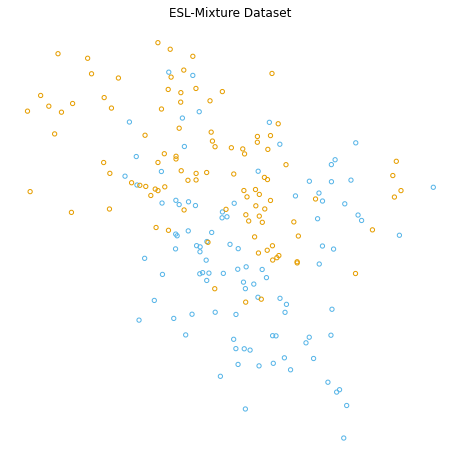

In [4]:
# visualize the data
plt = plot_2D(x, y, "ESL-Mixture Dataset", axis='off')

In [5]:
# prepare the data grid to visualize the decision bounday
x_1 = np.linspace(min(x[:, 0]), max(x[:, 0]), 1000)
x_2 = np.linspace(min(x[:, 1]), max(x[:, 1]), 1000)
x_1, x_2 = np.meshgrid(x_1,  x_2)
x_12 = np.concatenate((x_1.ravel().reshape(-1, 1), x_2.ravel().reshape(-1, 1)), axis=1)

#### Part 1: Calculate the density $P(g|X), g\in \mathcal{G}$ for each data point
Here, we calculate the density of the classes based on $N(m_k, \mathbf{I}/5)$ and $N(n_i, \mathbf{I}/5)$ for class 0 and class 1 respectively.

In [6]:
def density(x, means):
    dens = []
    for mean in means:
        dens.append(scipy.stats.multivariate_normal.pdf(x, mean, np.eye(2)/5))
    return np.mean(dens, axis=0)

class_0 = density(x_12, means[:10, :])
class_1 = density(x_12, means[10:, :])

#### Part 2: Find the maximum of $P(g|X), g\in \mathcal{G}$ w.r.t to $g\in \mathcal{G}$

In [7]:
Z = np.zeros_like(class_0)
Z[class_1 > class_0] = 1

### Plot the Bayes decision boundary

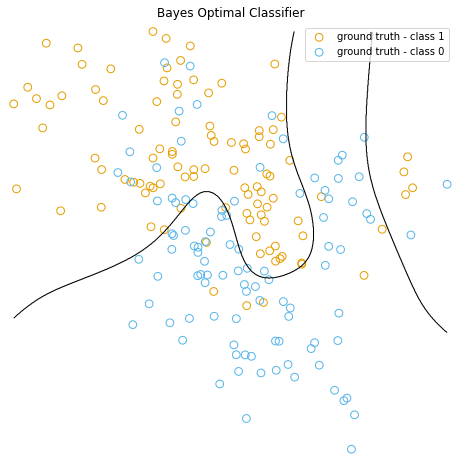

In [8]:
BLUE, ORANGE = "#57B5E8", "#E69E00"
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0][y==1], x[:, 1][y==1], s=60, marker="o", edgecolors=ORANGE, facecolors="none", label='ground truth - class 1')
plt.scatter(x[:, 0][y==0], x[:, 1][y==0], s=60, marker="o", edgecolors=BLUE, facecolors="none", label='ground truth - class 0')
plt.contour(x_1, x_2, Z.reshape(x_1.shape), colors="black", levels=[0], linewidths=1)
plt.legend()
plt.axis("off")
plt.title("Bayes Optimal Classifier")
plt.xlim([min(x[:, 0]) - 0.1, max(x[:, 0]) + 0.1])
plt.ylim([min(x[:, 1]) - 0.1, max(x[:, 1]) + 0.1])
plt.show()